# [프로젝트] P02 영화추천시스템
---
이름: 김태산

학과: 자동차공학과

학번: 20143211

---

## 모듈 불러오기
- 사용할 모듈 import 하기

In [1]:
import requests
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm import tqdm
from sklearn import decomposition

## Task 1. 데이터 준비하기

> ### Task 1-1. 파일을 다운로드 받고 ua.data 파일(학습데이터)과 ua.test 파일(검증데이터)의 내용을 불러와서 Tensor 데이터 생성하기
 - requests 라이브러리를 사용해 압축파일을 직접 다운로드 받고, zipfile 라이브러리를 사용해 필요한 파일만 찾아 압축을 푼다.

In [2]:
c = requests.get("http://files.grouplens.org/datasets/movielens/ml-100k.zip")

with open("movielens100k.zip", 'wb') as f:
  f.write(c.content)

In [3]:
with zipfile.ZipFile("/content/movielens100k.zip") as z:
  fileNames = z.namelist()
  for fn in fileNames:
    if "ua.base" in fn:
      z.extract(fn)
    elif "ua.test" in fn:
      z.extract(fn)
    elif "u.item" in fn:
      z.extract(fn)

> - pandas를 이용하여 ua.base 파일과 ua.test 파일의 내용을 불러온다.
- 불러온 데이터에서 Latent Factor 모델을 학습시킬 때 필요한 데이터를 골라 Tensor 데이터로 생성한다.
- movie_train과 movie_test에는 평점이 매겨진 영화 id가 입력된다.
- user_train과 user_test에는 평점을 매긴 사용자의 id가 입력된다.
- rating_train과 rating_test에는 영화의 평점이 입력된다.

In [4]:
trainingData = pd.read_csv("./ua.base", sep='\t', names=['user', 'movie', 'rating', 'timestamp'])
testData = pd.read_csv("./ua.test", sep='\t', names=['user', 'movie', 'rating', 'timestamp'])

movie_train = torch.tensor(trainingData['movie'])
user_train = torch.tensor(trainingData['user'])
rating_train = torch.FloatTensor(trainingData['rating'])

movie_test = torch.tensor(testData['movie'])
user_test = torch.tensor(testData['user'])
rating_test = torch.FloatTensor(testData['rating'])

> ### Task 1-2. u.item 파일로부터 영화 id와 title 불러오기
- u.item 파일은 '|'로 구분된 파일이고, 영화 id와 title은 첫번째와 두번째 열에 각각 입력되어 있으므로, usecols 파라미터를 이용하여 해당 열만 불러온다.


In [5]:
movieData = pd.read_csv("./u.item", sep='|', encoding = "ISO-8859-1", usecols=[0, 1], names=["Id", "Title"])
movie_id = movieData['Id']
movie_title = movieData['Title']
movieData

,Id,Title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


## Task 2. Latent Factor 모델을 이용하여 학습하기
> ### Task 2-1. P, Q, bias_user, bias_item 등 파라미터 초기화하기
 - P와 Q의 벡터 차원을 rank로 하고, 영화와 사용자 수를 계산하여 해당 크기의 난수로 초기화한다.
 - Global baseline estimation을 적용하기 위한 bias_item과 bias_user도 영화와 사용자 수에 맞는 크기의 난수로 초기화하고, 영화의 전체 평점 평균 mean_rating을 계산한다.
 - Regularization을 적용하기 위한 하이퍼파라미터 lambda1, lambda2, lambda3, lambda4를 초기화한다.

In [6]:
rank = 100
num_movies = movie_train.max() + 1 # 영화와 사용자 id는 1부터 시작하지만 파이썬 인덱스가 0부터 시작하기 때문에
num_users = user_train.max() + 1   # 마지막 id까지 포함시키기 위해서 1을 더해준다.

P = torch.randn(num_movies, rank, requires_grad=True)
Q = torch.randn(num_users, rank, requires_grad=True)
bias_item = torch.randn(num_movies, requires_grad=True)
bias_user = torch.randn(num_users, requires_grad=True)
mean_rating = rating_train.sum() / len(rating_train)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.00001
lambda4 = 0.00001

> ### Task 2-2. regularization과 bias 적용하여 가설, 비용 설정하기
  - 먼저 가설을 설정할 때 P와 Q를 내적하여 예상 평점을 계산하고, mean_rating과 bias_item, bias_user를 더하여 bias를 적용하며 global baseline estimation을 추가하였다.
  - 비용 cost를 설정할 때에는 먼저 F.mse_loss를 통해 가설과 실제 평점의 mse를 구하고 이를 1/2제곱하여 rmse를 계산하였다.
  - 또한 regularization을 적용하기 위해 각각의 파라미터의 L2 norm을 계산하고 하이퍼파라미터 lambda를 곱하여 rmse에 더해주었다.

> ### Task 2-3. torch.optim을 사용하여 학습하기
  - 이번 프로젝트에서 optimizer는 Adam을 사용하였다.
  - optimizer를 학습 전에 정의하고, 학습 시 먼저 optimizer.zero_grad()를 통해 이전에 계산된 그레디언트를 초기화시킨 후 optimizer.step()을 통해 매개변수를 갱신한다.

> ### Task 2-4. 학습데이터와 검증데이터에 대해서 각각 RMSE값을 구하여 출력하기(training RMSE, test RMSE)
 - 아래의 출력은 1000 epoch마다 학습데이터에 대한 RMSE와 검증데이터에 대한 RMSE를 구하여 출력한 것이다.
 - 출력 결과를 보면, 학습이 진행되면서 training RMSE와 test RMSE가 모두 감소하는 것으로 보아 Latent factor 모델이 학습데이터에 과대적합되지 않고 학습이 잘 진행된 것을 알 수 있다.
 - 또한 아래의 그래프는 1000 epoch마다 저장된 training RMSE와 test RMSE를 이용하여 그린 것으로, 이를 통해서도 모델이 학습데이터에 과대적합되지 않았음을 알 수 있다.

In [7]:
optimizer = optim.Adam([P, Q, bias_item, bias_user], lr=0.01)

epoches = []
trainingRMSE = []
testRMSE = []
for epoch in range(1001):
  hypothesis = (P[movie_train] * Q[user_train]).sum(dim=1) + mean_rating + bias_item[movie_train] + bias_user[user_train]
  rmse = F.mse_loss(hypothesis, rating_train) ** 0.5
  cost = rmse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum() + lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  epoches.append(epoch)
  trainingRMSE.append(rmse.item())

  with torch.no_grad():
    hypothesis_test = (P[movie_test] * Q[user_test]).sum(dim=1) + mean_rating + bias_item[movie_test] + bias_user[user_test]
    rmse_test = F.mse_loss(hypothesis_test, rating_test) ** 0.5
    testRMSE.append(rmse_test.item())
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch:4d}, training RMSE: {rmse.item():.6f}, test RMSE: {rmse_test.item():6f}")

epoch:    0, training RMSE: 10.223137, test RMSE: 10.061413
epoch:  100, training RMSE: 1.516721, test RMSE: 2.523590
epoch:  200, training RMSE: 0.607204, test RMSE: 1.181326
epoch:  300, training RMSE: 0.530246, test RMSE: 0.987261
epoch:  400, training RMSE: 0.527723, test RMSE: 0.949124
epoch:  500, training RMSE: 0.534084, test RMSE: 0.938640
epoch:  600, training RMSE: 0.538690, test RMSE: 0.935173
epoch:  700, training RMSE: 0.540937, test RMSE: 0.933835
epoch:  800, training RMSE: 0.541760, test RMSE: 0.933236
epoch:  900, training RMSE: 0.541794, test RMSE: 0.932933
epoch: 1000, training RMSE: 0.541431, test RMSE: 0.932776


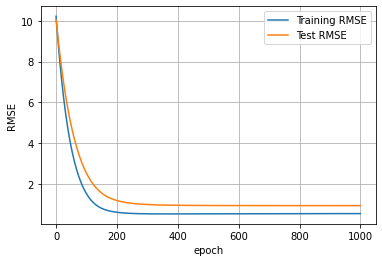

In [8]:
plt.plot(epoches, trainingRMSE, label='Training RMSE')
plt.plot(epoches, testRMSE, label='Test RMSE')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

## Task 3. 13번 User에게 추천하기(knn search)
> ### Task 3-1. 13번 user의 예상 별점이 가장 높은 영화 top 20개를 찾아서 id 및 영화이름 출력하기
- 먼저 위에서 구한 매개변수 P, Q, bias_item, bias_user는 더이상 기울기 계산을 하지 않아도 되므로 requires_grad를 False로 바꿔준다.
- 13번 user에 해당하는 벡터는 Q[13]이므로 이를 이용하여 13번 user의 예상 별점을 계산한다.
- 영화의 id는 1부터 시작하기 때문에 P의 첫번째 행은 사용하지 않는 값이 되므로 이를 제외하고 예상 별점을 계산하기 위해 P[1:]을 사용하였다.
- 먼저 P와 Q[13]의 내적을 구해 각각의 영화마다 예상 별점을 계산한다.
- 또한, 위에서 latent factor 모델을 학습시킬 때 global baseline estimation을 추가하였으므로, 예상 별점을 구할 때에도 이를 포함시켜주어야 한다.
- 이를 모두 포함시켜 13번 user의 예상 별점을 계산하고, 내림차순으로 정렬한다.
- 내림차순으로 정렬한 결과는 인덱스가 0부터 시작이므로 인덱스 값 전체에 1을 더해준 후 첫번째부터 20번째까지의 인덱스를 구하면 이 값이 예상 별점이 가장 높은 영화 top 20개의 id가 된다.
- top 20 영화 id를 통해 u.item 파일에서 불러온 영화 데이터에서 top 20 영화의 이름을 가져올 수 있다.
- 아래의 결과는 13번 user의 예상 별점이 가장 높은 영화 top 20개에 대한 id 및 영화이름을 pandas dataframe 형태로 출력한 것이다.

In [9]:
P.requires_grad_(False)
Q.requires_grad_(False)
bias_item.requires_grad_(False)
bias_user.requires_grad_(False)

user13 = Q[13]

rating_user13 = (P[1:] * user13).sum(dim=1) + mean_rating + bias_item[1:] + bias_user[13]

top20Id = (rating_user13.sort(descending=True)[1] + 1)[:20]
top20Id = top20Id.tolist()

top20Title = [movieData.loc[movieData['Id']==id, "Title"].to_numpy()[0] for id in top20Id]

top20 = np.array([top20Id, top20Title]).T
top20 = pd.DataFrame(top20, columns=['movieId', 'Title'])
top20

,movieId,Title
0,663,Being There (1979)
1,202,Groundhog Day (1993)
2,511,Lawrence of Arabia (1962)
3,50,Star Wars (1977)
4,430,Duck Soup (1933)
5,187,"Godfather: Part II, The (1974)"
6,285,Secrets & Lies (1996)
7,204,Back to the Future (1985)
8,655,Stand by Me (1986)
9,181,Return of the Jedi (1983)


> ### Task 3-2. Latent Matrix P와 Q를 이용하여 13번 user와 cosine similarity가 가장 유사한 영화 top 20개를 찾아서 id 및 영화이름 출력하기
- 먼저 Latent matrix P와 13번 user의 벡터 간의 cosine similarity를 구하기 위한 함수를 정의하였다.
- cosine_similarity 함수는 행렬 P의 각 영화의 벡터와 user 벡터의 내적 값을 두 벡터의 크기로 나누어 cosine similarity를 계산하고 이를 리턴한다.
- cosine similarity의 경우 Pytorch의 내장 함수인 torch.nn.functional.cosine_similarity()를 사용하여 계산할 수도 있다.
- knnMovie 함수는 knn의 갯수 k와 latent matrix P, user 벡터를 입력받아 user와 cosine similarity가 가장 유사한 영화 top k개를 찾고, top k개 영화의 id 및 영화이름을 pandas dataframe으로 리턴한다.
- 먼저 cosine_similarity() 함수를 사용하여 모든 영화와 user 간의 cosine_similarity를 계산한다.
- 이를 내림차순으로 정렬하여 나온 결과 중 인덱스 값에 1을 더해주면 user와의 cosine_similarity가 높은 순으로 영화 id를 구할 수 있다.
- 이 중에서 앞에서 20개의 값을 가져오면 user와 cosine similarity가 가장 유사한 영화 top 20개의 id를 찾을 수 있다.
- 위에서 구한 영화 id와 movieData 데이터프레임을 사용하면 해당 id의 영화이름을 찾을 수 있다.
- 영화 id와 영화 이름을 각각 리스트에 저장한 후, 이를 합하여 pandas DataFrame 형태로 만들어 리턴한다.

In [10]:
def knn_cosine_similarity(P, user):
  denom = ((P[1:] ** 2).sum(dim=1) * (user ** 2).sum()) ** 0.5
  for d in denom:
    if d != 0: continue
    else: return 10e-7
  return (P[1:] * user).sum(dim=1) / denom

def knnMovies(k, P, user):
  cos_top20Id = knn_cosine_similarity(P, user)
  cos_top20Id = (cos_top20Id.sort(descending=True)[1] + 1)[:k].tolist()

  cos_top20Title = [movieData.loc[movieData['Id']==id, "Title"].to_numpy()[0] for id in cos_top20Id]

  cos_top20 = np.array([cos_top20Id, cos_top20Title]).T
  cos_top20 = pd.DataFrame(cos_top20, columns=['movieId', 'Title'])
  return cos_top20

user13 = Q[13]
cosine_top20 = knnMovies(20, P, user13)
cosine_top20

,movieId,Title
0,814,"Great Day in Harlem, A (1994)"
1,791,"Baby-Sitters Club, The (1995)"
2,868,Hearts and Minds (1996)
3,848,"Murder, My Sweet (1944)"
4,263,Steel (1997)
5,909,Dangerous Beauty (1998)
6,867,"Whole Wide World, The (1996)"
7,733,Go Fish (1994)
8,917,Mercury Rising (1998)
9,811,Thirty-Two Short Films About Glenn Gould (1993)


## Task 4. 영화 클러스터링하기(k-means clustering)
> ### Task 4-1. 다음을 만족하는 k-means clustering 알고리즘 구현하기
 - `각 영화가 속한 cluster를 정할 때, cosine similarity를 기준으로 정하기`

> - 아래의 코드에서 kmeans() 함수를 통해 데이터를 k개로 clustering하고 각각의 cluster에 대한 중심점을 계산하여 리턴한다.
- 중심점을 초기화할 때에는 forgy 방법을 이용하여, 데이터 내에서 임의의 k개의 점을 선택한다.
- 그리고 데이터의 모든 점과 중심점과의 cosine similarity를 계산하여 cosine similarity가 가장 큰 중심점의 cluster에 각각의 점을 포함시킨다.
- k개의 클러스터에 포함된 점들의 평균점을 계산하여 새로운 중심점을 찾는다.
- kmeans() 함수에서는 새로운 중심점을 계산하는 과정을 10 epoch만큼 반복하고, 중간에 cluster의 변화가 없을 경우 반복을 중단한다.
- 중심점 계산이 완료되면, 중심점과 각각의 점들이 포함되는 cluster의 인덱스 리스트를 리턴한다.

> - 아래의 코드에서 assign_centroid()는 데이터의 각각의 점들이 포함될 cluster에 해당하는 중심점의 인덱스를 계산해주는 함수이다.
- 각 영화가 속한 cluster를 정할 때 cosine similarity를 기준으로 정하고, cosine similarity의 경우 값이 클수록 중심점과 영화의 유사도가 높은 것을 의미하므로 먼저 cosine similarity가 입력될 maxCosine을 매우 작은 값으로 초기화한다.
- 각각의 중심점에 대해 입력된 영화 벡터와 cosine similarity를 계산하여 그 값이 가장 큰 중심점의 인덱스를 centroidIdx에 입력하고 이를 리턴한다.

> - new_centroids()는 assign_centroid를 통해 계산된 cluster의 점들을 평균하여 새로운 중심점을 계산하는 함수이다.
- 먼저 포함될 cluster의 인덱스 리스트 assignments를 이용하여 모든 점들을 cluster에 입력하고, 각각의 cluster마다 평균점을 계산하여 k개의 중심점을 구해 이를 리턴하다.

In [11]:
def cosine_similarity(point, centroid):
  denom = ((point ** 2).sum() * (centroid ** 2).sum()) ** 0.5
  if denom == 0:
    denom = 10e-10
  
  cosine = (point * centroid).sum() / denom
  return cosine

def assign_centroid(point, centroids):
  centroidIdx = -1
  maxCosine = -10

  for idx, c in enumerate(centroids):
    cos_sim = cosine_similarity(point, c)
    
    if cos_sim > maxCosine:
      maxCosine = cos_sim
      centroidIdx = idx

  return centroidIdx

def new_centroids(points, assignments, k):
  clusters = [[] for _ in range(k)]
  for p, a in zip(points, assignments):
    clusters[a].append(p)
  
  centroids = [np.mean(c, axis=0) if len(c) != 0 else random.choices(points)[0] for c in clusters]
  return centroids
  
def kmeans(points, k):
  prev_assignments = []

  centroids = random.choices(points, k=k)

  for epoch in range(10):
    assignments = [assign_centroid(p, centroids) for p in points]
    centroids = new_centroids(points, assignments, k)
    if prev_assignments == assignments: break
    prev_assignments = assignments
  
  
  return centroids, assignments

> ### Task 4-2. k = 1, ..., 40까지 바꿔가면서 cost 값을 계산하고 이를 matplotlib을 활용하여 그래프로 그리기
- 먼저 영화 데이터 mpoints와 중심점의 갯수 k(k = 1, ..., 40)를 kmeans() 함수에 입력하여 중심점 centroids와 cluster에 해당하는 인덱스 리스트 assignments를 구한다.
- 이를 getClusters() 함수에 입력하여 영화 데이터의 모든 점을 자신이 속한 cluster에 포함시켜 k개의 cluster를 구한다.
- cost는 각각의 cluster의 모든 점과 해당 cluster의 cosine similarity를 계산하고 모두 합한 후 이를 1에서 빼주었다.
- cosine similarity의 범위는 -1 <= c <= 1이므로 이를 1에서 빼면 cost는 0 <= cost <= 2의 범위를 가지게 되고, cost의 값이 작을수록 cosine similarity는 큰 것을 의미한다.
- cosine similarity가 클수록 clustering이 잘 된 것을 의미하고 이 때 cost는 작아지게 되므로 이는 cost의 조건에 부합한다.
- cost를 계산하는 함수는 compute_cost()를 통해 구현하였다.
- k를 1부터 40까지 변화시켜 가며 각각의 cost를 계산하고, 이를 costs에 모두 입력하여 아래의 그래프와 같이 k에 대한 cost를 시각화하였다.
- 그래프 결과를 보면, k가 커질수록 cost는 작아지는 것으로 보아 kmeans() 함수가 중심점과 cluster를 적절하게 구하였다는 것을 알 수 있다.


In [12]:
mpoints = P.numpy()
costs = []

def getClusters(points, assignments, k):
  clusters = [[] for _ in range(k)]
  for p, a in zip(points, assignments):
    clusters[a].append(p)
  return clusters

def compute_cost(clusters, centroids):
  clusters = [np.array(c) for c in clusters]
  cost = sum(1 - cosine_similarity(c, centroid) for cluster, centroid in zip(clusters, centroids) for c in cluster)
  return cost

for k in tqdm(range(1, 41)):
  centroids, assignments = kmeans(mpoints, k)

  clusters = getClusters(mpoints, assignments, k)

  cost = compute_cost(clusters, centroids)
  costs.append(cost)

100%|██████████| 40/40 [03:54<00:00,  5.85s/it]


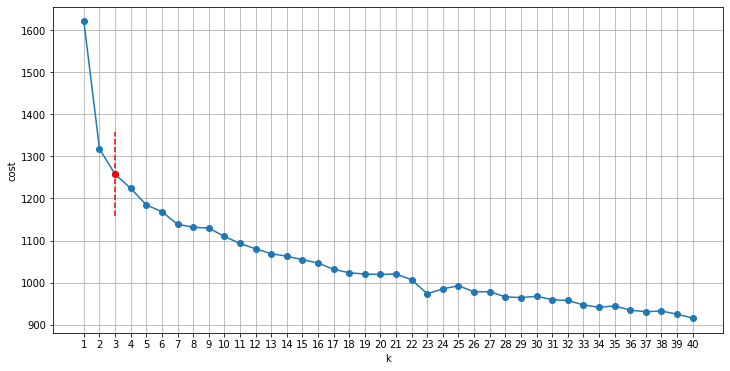

In [13]:
k = 3
plt.figure(figsize=(12,6))
plt.plot(range(1, 41), costs, 'o-')
plt.plot(k, costs[k-1], 'ro')
plt.plot([k, k], [costs[k-1] - 100, costs[k-1] + 100], 'r--')
plt.xlabel("k")
plt.ylabel("cost")
plt.xticks(range(1, 41))
plt.grid()
plt.show()

> ### Task 4-3. 가장 적절해보이는 k 선택하기
- 가장 적절한 k를 선택하기 위해서는 k를 1부터 증가시켜가며 cost를 분석해보아야 한다.
- k가 증가할수록 cost는 계속해서 감소한다는 이유로 cost가 최소인 가장 큰 k를 선택하는 것은 적절하지 않다.
- 극단적인 예로, k가 데이터의 전체 점의 갯수와 같을 경우 cluster의 갯수는 전체 점의 갯수와 같아지고 이 때의 cost는 0이 되는데, 이는 kmeans clustering을 하였다고 볼 수 없다.
- 따라서 적절한 k를 선택할 때에는 cost의 감소가 큰 구간과 작은 구간을 나누는 점인 elbow point를 선택하는 것이 좋다.
- 그러나 위의 그래프를 보면, elbow point를 구분하기가 명확하지 않으므로 cost의 감소가 큰 구간과 작은 구간을 시각적으로만 구분하여 임의로 k=3을 적절한 k로 선택하였다. 

## Task 5. 차원 축소 및 시각화(PCA)
> ### Task 5-1. P 행렬과 Q 행렬을 합쳐 Z 행렬 만들기
- P 행렬과 Q 행렬을 합칠 때에는 torch.cat() 함수를 사용하였다.
- 아래의 출력을 보면, Z의 크기는 2627 * 100이고, P 행렬과 Q 행렬의 행의 길이 합이 Z 행렬의 행의 길이와 같은 2627인 것으로 보아 두 행렬이 잘 합쳐진 것을 알 수 있다.


In [14]:
Z = torch.cat([P, Q])
print("Z.shape:", Z.shape)
print("P.shape[0] + Q.shape[0]:", P.shape[0] + Q.shape[0])

Z.shape: torch.Size([2627, 100])
P.shape[0] + Q.shape[0]: 2627


> ### Task 5-2. Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기
  - `참고: 외부 library를 사용해도 무방함`

  



> - PCA를 수행할 때에는 사이킷런의 decomposition.PCA()를 사용하였다.
- 2차원 데이터로 차원 축소를 하는 PCA 객체를 생성하고, Z 행렬을 fit과 transform을 이용하여 Zp로 차원 축소시킨다.
- 아래의 출력은 Z 행렬과 Zp 행렬의 크기를 나타낸 것이다.
- 기존에 100차원이던 Z 행렬이 2차원의 Zp 행렬로 차원 축소된 것을 확인할 수 있다.

In [15]:
pca = decomposition.PCA(2)
pca.fit(Z)
Zp = pca.transform(Z)

print(Z.numpy().shape)
print(Zp.shape)

(2627, 100)
(2627, 2)


> ### Task 5-3. matplotlib을 활용하여 Zp의 scatter plot 그리기
 - #### Task 5-3-1. P 행렬과 Q 행렬의 점들을 서로 다른 색으로 그리기
  - 아래의 그래프는 Zp의 모든 점들을 시각화한 것이다.
  - P와 Q를 Z로 합칠 때 Q를 P의 아래 행에 오도록 합쳤기 때문에 Zp의 첫 행부터 P의 행 크기만큼의 행까지는 P에 해당하는 점이고, 나머지가 Q에 해당하는 점이다.
  - P의 행 크기는 아래의 출력과 같이 1683이므로 이를 이용하여 P 행렬과 Q 행렬의 점들을 서로 다른 색으로 그린다.
  - P에 해당하는 점은 녹색으로, Q에 해당하는 점은 황색으로 시각화하였다.

P.shape[0]: 1683


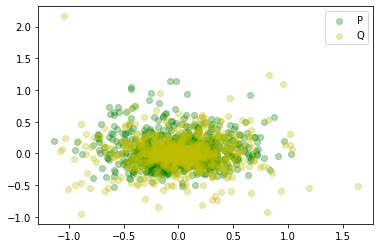

In [16]:
print("P.shape[0]:", P.shape[0])
plt.scatter(Zp[:1683, 0], Zp[:1683, 1], c='g', alpha=0.3, label='P')
plt.scatter(Zp[1683:, 0], Zp[1683:, 1], c='y', alpha=0.3, label='Q')
plt.legend()
plt.show()

> ### Task 5-3. matplotlib을 활용하여 Zp의 scatter plot 그리기
 - #### Task 5-3-2. Task 3의 결과 점들을 다른 색으로 그려 강조하기
  - 먼저 Zp에 해당하는 모든 점들을 노란색으로 시각화하였다.
  - 그래프의 빨간색에 해당하는 점들은 Task 3-1에서 13번 사용자의 top20 예상 별점에 해당하는 영화를 그린 것이다.
  - 그래프의 파란색에 해당하는 점들은 Task 3-2에서 13번 사용자와 cosine similarity가 높은 20개의 영화를 그린 것이다.
  - 마지막으로 하늘색에 해당하는 점은 13번 사용자에 해당하는 점이다.
  - 결과를 보면, 13번 사용자와 cosine similarity가 높은 점들은 서로 몰려있는 것을 확인할 수 있다.
  -  두 벡터 사이의 각도가 0에 가까울수록 cosine similarity는 커지므로 13번 사용자 벡터와의 각도가 작은 영화 벡터들이 몰려있는 것으로 보인다.

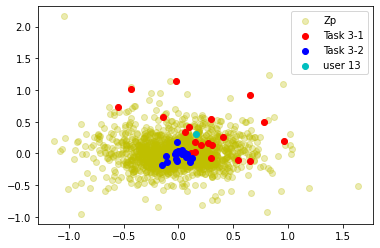

In [17]:
q3_1 = Zp[top20Id]
q3_2 = Zp[pd.to_numeric(cosine_top20.movieId)]

plt.scatter(Zp[:, 0], Zp[:, 1], c='y', alpha=0.3, label='Zp')

plt.scatter(q3_1[:, 0], q3_1[:, 1], c='r', label='Task 3-1')
plt.scatter(q3_2[:, 0], q3_2[:, 1], c='b', label='Task 3-2')
plt.scatter(Zp[1696, 0], Zp[1696, 1], c='c', label='user 13')
plt.legend()
plt.show()

> ### Task 5-3. matplotlib을 활용하여 Zp의 scatter plot 그리기
 - #### Task 5-3-3. Task 4에서 구한 cluster들을 각기 다른 색으로 그리기
  - 아래의 그래프는 k=3, 즉, Task 4에서 P를 3개의 cluster로 clustering하고 이를 각각의 cluster 별로 시각화한 것이다.
  - P를 clustering하고 이에 해당하는 cluster의 인덱스인 assignments를 이용하여 서로 다른 색으로 Zp를 그린 결과를 보면, 각각의 cluster들이 잘 나뉘어 있는 것을 확인할 수 있다.
  - 추가로 빨간색에 해당하는 그래프는 Q에 해당하는 점들을 의미한다.

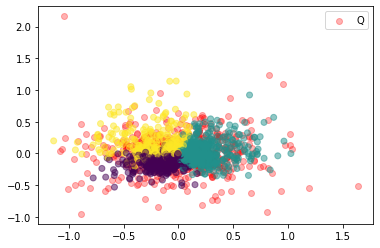

In [23]:
k = 3
centroids, assignments = kmeans(mpoints, k)

color = {s: i for i, s in enumerate(set(assignments))}

plt.scatter(Zp[1683:, 0], Zp[1683:, 1], c='r', alpha=0.3, label='Q')
plt.scatter(Zp[:1683, 0], Zp[:1683, 1], c=[color[a] for a in assignments], alpha=0.5)

plt.legend()
plt.show()